# Text Classification (supervised learning) 

In this tutorial, we will illustrate the idea of text classification using The SMS spam dataset. The problem is to predict if a phone sms message is spam or not.

* Import the csv file that contains the SMS spam data set.
* There are two class labels `ham` (not spam) and `spam`

In [2]:
import pandas as pd

In [4]:
sms_msgs = pd.read_csv('sms_spam.csv',names= ['class', 'sms'],header=1)
sms_msgs

,class,sms
0,ham,K..give back my thanks.
1,ham,Am also doing in cbe only. But have to pay.
2,spam,"complimentary 4 STAR Ibiza Holiday or £10,000 ..."
3,spam,okmail: Dear Dave this is your final notice to...
4,ham,Aiya we discuss later lar... Pick u up at 4 is...
...,...,...
5553,ham,You are a great role model. You are giving so ...
5554,ham,"Awesome, I remember the last time we got someb..."
5555,spam,"If you don't, your prize will go to another cu..."
5556,spam,"SMS. ac JSco: Energy is high, but u may not kn..."


How many messages are spam and not-spam. 

* You can see here that the number of messages belonging to different classes are not equal. 
* There is a class imbalance here. This should be corrected ideally. But for now lets not worry about it.

In [5]:
sms_msgs['class'].value_counts()

ham     4811
spam     747
Name: class, dtype: int64

### Split the data into 80% training set and 20% testing set

In [6]:
sms_label = sms_msgs['class']
sms_text  = sms_msgs['sms']

In [7]:
from sklearn.model_selection import train_test_split
msg_train, msg_test, label_train, label_test = train_test_split(sms_text, sms_label, test_size=0.2)

* `msg_train`: training data contains training text data
* `msg_test` : testing data contains testing text data
* `label_train`: class label for training text
* `label_test` : class label for testing text


In [8]:
print(msg_train.shape)
print(msg_test.shape)
print(label_train.shape)
print(label_test.shape)

(4446,)
(1112,)
(4446,)
(1112,)


### TFIDF of words as features.

* Fit the `tfidfvectorizer` on the training set
* Use the same  `tfidfvectorizer` to transform the testing set
* This makes sure that the vocabulary (learned from training set) is used on the testing set. 


In [9]:
from nltk.tokenize import TreebankWordTokenizer
import spacy
nlp = spacy.load("en_core_web_sm")

A function to perform preprocessing steps:

    - tokenization
    - filtering
    - lemmantization/stemming

In [10]:
import string, re
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
def my_tokenizer(text):
    '''
    tokenize
    '''
    tokenizer = TreebankWordTokenizer()
    tokens = tokenizer.tokenize(text.lower())
    #print(tokens)
    '''
    This is the step to remove tokens which are not needed
    In this example, removing all punctuations and remove stop words
    '''
    
    #tokens = [word for word in tokens if word not in string.punctuation]
    tokens = [word for word in tokens if word not in stop_words]
    #tokens = [word for word in tokens if len(word) > 3]

    #print(tokens)
    '''
    lemmantization
    '''
    doc = nlp(' '.join(tokens))
    tokens = [word.lemma_ for word in doc]
    
    '''
    removing stop words and punctuation marks again.
    lemmantization may create some of these
    '''
    #tokens = [word for word in tokens if word not in string.punctuation]
    tokens = [word for word in tokens if word not in stop_words]
    #tokens = [word for word in tokens if len(word) > 3 ]
    return tokens


In [11]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

'''
First fit the tfidfvectorizer on the training set
'''

corpus_train=msg_train.to_list()
vectorizer = TfidfVectorizer(min_df=10,analyzer=my_tokenizer) 
sms_train_tfidf = vectorizer.fit_transform(corpus_train)
sms_train_tfidf = sms_train_tfidf.todense()
print(sms_train_tfidf.shape)


'''
Use the same  tfidfvectorizer to transform the testing set
'''

corpus_test=msg_test.to_list()
sms_test_tfidf = vectorizer.transform(corpus_test)
sms_test_tfidf = sms_test_tfidf.todense()
print(sms_test_tfidf.shape)


(4446, 708)
(1112, 708)


A row in `sms_train_tfidf` represent an sms. The columns in `sms_train_tfidf` represent the features. Testing data is `sms_test_tfidf`

### Blancing training set and fitting the model

Use SMOTE (Synthetic Minority Over-sampling Technique) algorithm to create artificial data belonging to the minority class

SMOTE algorithm: https://arxiv.org/abs/1106.1813

NOTE: this step is only needed if there is an imbalance of rows belonging to different classes in the training set.

In [12]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
sms_train_tfidf_balanced, label_train_balanced = sm.fit_resample(sms_train_tfidf, label_train)
print('number of class labels in the balanced training set\n', label_train_balanced.value_counts())

number of class labels in the balanced training set
 ham     3855
spam    3855
Name: class, dtype: int64


* `sms_train_tfidf_balanced`: new training set which is balanced
* `label_train_balanced`: class labels of the new training set

### Neural Network models

Here, we will build three versions of a neural network. 

#### First model

* `number of hidden layer` = 1 with 50 nodes. The network will have one input layer and one output layer and 1 hidden layer.
* `validation_fraction`: During the optimization process, fraction of the training set will be used as a `validation` data. The weights in the model will be updated by optimizing the difference between the predictions by the model in the `validation` data and actual class labels of the validation data.
* `early_stopping`: terminate training when validation score is not improving. 



In [15]:
from sklearn.neural_network import MLPClassifier
nn_model1 = MLPClassifier(hidden_layer_sizes=(50,),activation='relu',early_stopping=True,validation_fraction=0.1)

#### Second model

* `number of hidden layer` = 2. Each hidden layer will have 50 nodes. The network will have one input layer and one output layer and 2 hidden layers.


In [16]:
nn_model2 = MLPClassifier(hidden_layer_sizes=(50,50,),activation='relu',early_stopping=True,validation_fraction=0.1)

#### Third model


* `number of hidden layer` = 3. Each hidden layer will have 50 nodes. The network will have one input layer and one output layer and 3 hidden layers.


In [17]:
nn_model3 = MLPClassifier(hidden_layer_sizes=(50,50,50),activation='relu',early_stopping=True, validation_fraction=0.1)

### Training the models

The training optimizes the log-loss function (or binary cross entropy) by updating the weights in the model using an optimization algorithm.

In [18]:
nn_model1.fit(sms_train_tfidf_balanced, label_train_balanced)
nn_model2.fit(sms_train_tfidf_balanced, label_train_balanced)
nn_model3.fit(sms_train_tfidf_balanced, label_train_balanced)

MLPClassifier(early_stopping=True, hidden_layer_sizes=(50, 50, 50))

### Function to get the accuracy on each class of the testing data

In [19]:
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay
def get_accuracy(model,test_data,test_classes):
    predictions = model.predict(test_data) # predictions
    cm = confusion_matrix(test_classes, predictions, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
    disp.plot()
    
    print('Accuracy for ham class is', 100*cm[0,0]/(cm[0,0]+cm[0,1]))
    print('Accuracy for spam class is', 100*cm[1,1]/(cm[1,0]+cm[1,1]))

#### Accuracy of first model on the testing data set

Accuracy for ham class is 96.96652719665272
Accuracy for spam class is 92.3076923076923


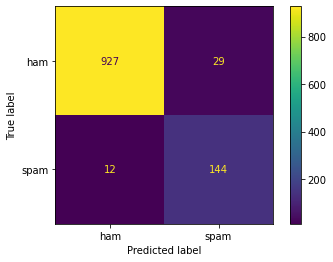

In [20]:
get_accuracy(nn_model1,sms_test_tfidf,label_test)

#### Accuracy of second model on the testing data set

Accuracy for ham class is 97.59414225941423
Accuracy for spam class is 91.66666666666667


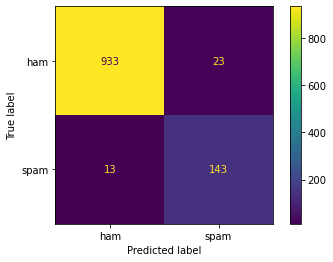

In [23]:
get_accuracy(nn_model2,sms_test_tfidf,label_test)

#### Accuracy of Third model on the testing data set

Accuracy for ham class is 98.11715481171548
Accuracy for spam class is 91.02564102564102


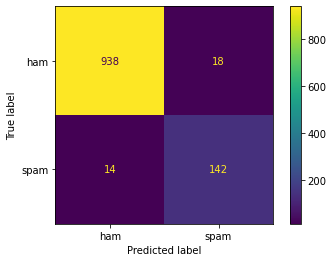

In [22]:
get_accuracy(nn_model3,sms_test_tfidf,label_test)

### Extracting weights from the model

In [29]:
print("Model1 with one hidden layer with 50 nodes")
print(len(nn_model1.coefs_))
print("weights between input layer and hidden layer", nn_model1.coefs_[0].shape)
print("weights between hidden layer and output layer",nn_model1.coefs_[1].shape)


print("biases for nn model 1 ")
print(len(nn_model1.intercepts_))
print("biases to hidden layer 1",nn_model1.intercepts_[0].shape)
print("biases to output layer",nn_model1.intercepts_[1].shape)

Model1 with one hidden layer with 50 nodes
2
weights between input layer and hidden layer (708, 50)
weights between hidden layer and output layer (50, 1)
biases for nn model 1 
2
biases to hidden layer 1 (50,)
biases to output layer (1,)


* (708,50): number of nodes in input layer and hidden layer are 708 and 50, respectively.
* (50,1): number of nodes in hidden layer and output layer are 50, and 1, respectively.

In [31]:
print("Model2 with two hidden layers with 50 nodes")
print(len(nn_model2.coefs_))
print("weights between input layer and hidden layer1", nn_model2.coefs_[0].shape)
print("weights between hidden layer1 and hidden layer2",nn_model2.coefs_[1].shape)
print("weights between hidden layer2 and output layer",nn_model2.coefs_[2].shape)


print("biases for nn model 2 ")
print(len(nn_model2.intercepts_))
print("biases to hidden layer 1",nn_model2.intercepts_[0].shape)
print("biases to hidden layer 2",nn_model2.intercepts_[1].shape)
print("biases to output layer",nn_model2.intercepts_[2].shape)

Model2 with two hidden layers with 50 nodes
3
weights between input layer and hidden layer1 (708, 50)
weights between hidden layer1 and hidden layer2 (50, 50)
weights between hidden layer2 and output layer (50, 1)
biases for nn model 2 
3
biases to hidden layer 1 (50,)
biases to hidden layer 2 (50,)
biases to output layer (1,)


In [32]:
print("Model3 with three hidden layers with 50 nodes")
print(len(nn_model3.coefs_))
print("weights between input layer and hidden layer1", nn_model3.coefs_[0].shape)
print("weights between hidden layer1 and hidden layer2",nn_model3.coefs_[1].shape)
print("weights between hidden layer2 and output layer3",nn_model3.coefs_[2].shape)
print("weights between hidden layer3 and output layer",nn_model3.coefs_[3].shape)

print("biases for nn model 3 ")

print(len(nn_model3.intercepts_))
print("biases to hidden layer 1",nn_model3.intercepts_[0].shape)
print("biases to hidden layer 2",nn_model3.intercepts_[1].shape)
print("biases to hidden layer 3",nn_model3.intercepts_[2].shape)
print("biases to output layer",nn_model3.intercepts_[3].shape)

Model3 with three hidden layers with 50 nodes
4
weights between input layer and hidden layer1 (708, 50)
weights between hidden layer1 and hidden layer2 (50, 50)
weights between hidden layer2 and output layer3 (50, 50)
weights between hidden layer3 and output layer (50, 1)
biases for nn model 3 
4
biases to hidden layer 1 (50,)
biases to hidden layer 2 (50,)
biases to hidden layer 3 (50,)
biases to output layer (1,)


### Predicted class labels

In [33]:
predictions = nn_model1.predict(sms_test_tfidf)
predictions

array(['ham', 'ham', 'spam', ..., 'ham', 'ham', 'spam'], dtype='<U4')

### Predicted class labels probabilities

In [34]:
predictions_prob = nn_model1.predict_proba(sms_test_tfidf)
predictions_prob

array([[6.07470193e-01, 3.92529807e-01],
       [9.91083575e-01, 8.91642535e-03],
       [6.98762745e-02, 9.30123725e-01],
       ...,
       [9.70367607e-01, 2.96323932e-02],
       [9.76216728e-01, 2.37832717e-02],
       [4.04709745e-04, 9.99595290e-01]])

In [ ]:
import math
w1=-0.0124
w2=-0.001
w3=-1.148
w4=0.941
w5=-0.773
w6=0.102

#hidden layer outputs
h1out=max(0,w1*x + w3*y)
h2out=max(0,w2*x + w4*y)

#output layer
p=math.exp(w5*h1out + w6*h2out)/(1+math.exp(w5*h1out + w6*h2out))
print(p)